In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from mpl_toolkits.mplot3d import Axes3D

path = '../output_data/test_output/'

,O1,O2,O3,O4,O5,O6,O7,O8
sample,,,,,,,,
2,0,6,34,11,2,26,12,9
0,6,22,35,9,10,0,6,12
3,28,4,15,1,11,1,7,33
1,9,14,6,1,25,11,5,29
4,6,11,29,4,41,1,6,2


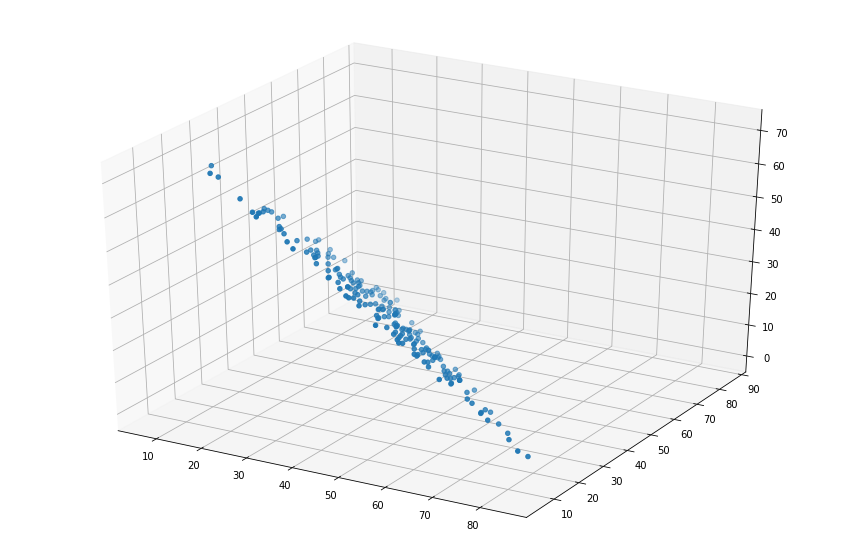

In [2]:
# with pd.HDFStore(path + 'X0a_ffh.h5') as store:
#     opd = store.select('dat_0')
with pd.HDFStore(path + 'X0_ffh.h5') as store:
    opd = store.select('dat_0',  where='eps=0.02 & phi=0.5')
opd.index = opd.index.droplevel(['eps', 'phi', 'ffh', 'test'])
opinions = opd.xs(level=1, key='opinions')

# for use with new data:
# dfN = opinions

# for use with old data:
dfN = pd.DataFrame(index=opinions.index)
for i in range(8):
    dfN[f'O{i+1}'] = (opinions==i).sum(axis=1)

dfN_vis = pd.DataFrame(index=dfN.index)
dfN_vis['x'] = dfN['O1'] + dfN['O2'] + dfN['O3']
dfN_vis['y'] = dfN['O4'] + dfN['O5'] + dfN['O6']
dfN_vis['z'] = dfN['O7'] + dfN['O8']

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=dfN_vis[['x']], ys=dfN_vis[['y']], zs=dfN_vis['z'])
dfN.head()

In [3]:
with pd.HDFStore(path + 'X0_ffh.h5') as store:
    trj = store.select('dat_1', where='eps=0.02 & phi=0.5')
trj.index = trj.index.droplevel(['eps', 'phi', 'ffh', 'test'])
trj.head()

C             G   G_alpha           K_c  \
sample tstep                                                       
2      0.00   7.797921e+14  1.155583e+06  0.680798  3.119287e+14   
       0.05   7.819660e+14  1.155054e+06  0.680404  3.133471e+14   
       0.10   7.841470e+14  1.154524e+06  0.680010  3.139684e+14   
       0.15   7.863350e+14  1.153995e+06  0.679616  3.146657e+14   
       0.20   7.885288e+14  1.153467e+06  0.679223  3.152318e+14   

                  K_c_cost           K_d      K_d_cost             L  \
sample tstep                                                           
2      0.00   1.962913e+13  2.041857e+15  1.521939e+14  3.288421e+09   
       0.05   1.974517e+13  2.040154e+15  1.520659e+14  3.288421e+09   
       0.10   1.981065e+13  2.039247e+15  1.519916e+14  3.288421e+09   
       0.15   1.988229e+13  2.038252e+15  1.519106e+14  3.288421e+09   
       0.20   1.994356e+13  2.037412e+15  1.518411e+14  3.288421e+09   

                       P_c      P_c_cost    ...      d[4, 3]  decision state  \
sample tstep                                ...                                
2      0.00   3.756705e+08  3.925826e+13    ...      0.00000        0.000000   
       0.05   3.779176e+08  3.949034e+13    ...      0.07407        0.164601   
       0.10   3.791904e+08  3.962131e+13    ...      0.09000        0.230000   
       0.15   3.805824e+08  3.976458e+13    ...      0.09000        0.226892   
       0.20   3.817735e+08  3.988712e+13    ...      0.09000        0.220000   

                   i_c       r_c   r_c_dot       r_d   r_d_dot  time  \
sample tstep                                                           
2      0.00   0.508899  0.062928  0.000000  0.074537  0.000000  0.00   
       0.05   0.253766  0.063014  0.001758  0.074536 -0.000114  0.05   
       0.10   0.229974  0.063098  0.001124  0.074533 -0.000054  0.10   
       0.15   0.226821  0.063185  0.001566  0.074530 -0.000064  0.15   
       0.20   0.219863  0.063266  0.001608  0.074526 -0.000065  0.20   

                       wage  sample_id  
sample tstep                            
2      0.00   104501.828581        NaN  
       0.05   104494.572414        NaN  
       0.10   104489.202846        NaN  
       0.15   104483.518445        NaN  
       0.20   104478.482063        NaN  

[5 rows x 50 columns]

In [4]:
cond = pd.DataFrame(index=trj.index)
cond['a'] = trj['K_c']/trj['K_d'] - 0.15276374882897656
cond['b'] = trj['i_c']
cond['c'] = trj['r_c']
cond.head()

a         b         c
sample tstep                              
2      0.00   0.000003  0.508899  0.062928
       0.05   0.000826  0.253766  0.063014
       0.10   0.001199  0.229974  0.063098
       0.15   0.001616  0.226821  0.063185
       0.20   0.001958  0.219863  0.063266

In [5]:
t_max=9

# calculate point distance
cond['d'] = np.sqrt((cond['a'])**2)

# sum over point distance for each trajectory
dfN['distance'] = cond['d'].unstack('sample').loc[:t_max].sum(axis=0)

# map distances to interval (0,1]
dfN['inv_distance'] = 1./(1. + dfN['distance'])

# use 1/distance as weight
dfN['weight'] = 1./cond['d'].unstack('sample').loc[:t_max].sum(axis=0)
dfN['weight'] = dfN['weight']/sum(dfN['weight'].values)

for s in dfN.index.values:
    cond.loc[(s,list(cond.index.levels[1])), 'inv_distance'] = dfN.loc[s, 'inv_distance']
dfN['weight'].sum()
dfN.head()

,O1,O2,O3,O4,O5,O6,O7,O8,distance,inv_distance,weight
sample,,,,,,,,,,,
2,0,6,34,11,2,26,12,9,8.082994,0.110096,0.002390
0,6,22,35,9,10,0,6,12,40.126993,0.024315,0.000481
3,28,4,15,1,11,1,7,33,3.309470,0.232047,0.005836
1,9,14,6,1,25,11,5,29,4.117650,0.195402,0.004691
4,6,11,29,4,41,1,6,2,55.232862,0.017783,0.000350


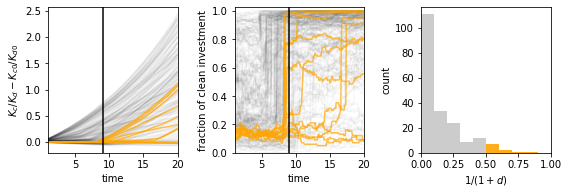

In [86]:
from collections import Counter

fig, axes = plt.subplots(ncols=3, figsize=(8, 2.8))

def plot_cond(df, c, ax, t_max, thresh=0.5):
    tmp = df
    tmp1 = tmp[[c]].loc[tmp['inv_distance']<thresh]
    tmp2 = tmp[[c]].loc[tmp['inv_distance']>thresh]
    try:
        tmp1.unstack('sample').loc[:t_max].plot(ax=ax, alpha=.03, legend=False, color=['k'])
    except TypeError:
        print('no data')
    try:
        tmp2.unstack('sample').loc[:t_max].plot(ax=ax, legend=False, alpha=.7, color=['orange'])
    except TypeError:
        print('no data')
    
thresh=0.5

plot_cond(cond, 'a', axes[0], 20, thresh=thresh)
plot_cond(cond, 'b', axes[1], 20, thresh=thresh)

try:
    dfN['inv_distance'].loc[dfN['inv_distance']>thresh].plot.hist(ax=axes[2], color=['orange'], alpha=0.9, bins=0.1*np.arange(5,11))
    dfN['inv_distance'].loc[dfN['inv_distance']<thresh].plot.hist(ax=axes[2], color=['k'], alpha=0.2, bins=0.1*np.arange(0,6))
except TypeError:
    print('no data')

#plt.yscale('log', nonposy='clip')

# dfN['weight'].loc[dfN['weight']<thresh].plot(ax=axes[2], style='.', alpha=0.3, color='k')
# dfN['weight'].loc[dfN['weight']>thresh].plot(ax=axes[2], style='.', color='orange')

for ax in axes[:2]:
    ax.set_xlim([1,20])
    ax.set_xlabel('time')
    ax.axvline(t_max, color='k')

axes[0].set_ylabel(r'$K_c/K_d - K_{c0}/K_{d0}$')
axes[1].set_ylabel('fraction of clean investment')
axes[1].set_ylim((0,1.03))
axes[2].set_ylabel('count')
axes[2].set_xlabel(r'$1/(1+d)$')
axes[2].set_xlim([0,1])

fig.tight_layout()
fig.savefig('initial_condition_sampling.pdf')

In [ ]:
oNames = [f'O{i+1}' for i in range(8)]

dfN_norm = pd.DataFrame(index=dfN.index, columns=dfN.columns)

for i in range(len(dfN)):
    dfN_norm.loc[i, oNames] = dfN.loc[i, oNames] * dfN['weight'][i]
dfN_norm['weight'] = dfN['weight']
print([round(x) for x in dfN_norm.sum()])
print(sum([round(x) for x in dfN_norm[oNames].sum()]))
print(dfN_norm.weight.sum())

In [ ]:
print(sum([15, 8, 12, 12, 14, 17, 7, 16]))
print(sum([14, 7, 15, 13, 12, 16, 7, 16]))

In [ ]:
# initial opinions:
fitted_opinions_distribution = [15, 8, 12, 12, 14, 17, 7, 16]
x = [2 * x for x in fitted_opinions_distribution]
opinions = []

for i, xi in enumerate(x):
    opinions += int(np.round(xi)) * [i]
np.random.shuffle(opinions)
# as the fitted distribution has one count to many, I have to leave two out
# here.
opinions = opinions[:-2]

In [ ]:
from collections import Counter
cnt = Counter(opinions)
for i in range(7):
    print(i, cnt[i])
print(cnt.keys())
print(cnt.values())

In [ ]:
0 30
1 16
2 24
3 24
4 27
5 34
6 14
dict_keys([5, 2, 7, 0, 6, 3, 4, 1])
dict_values([34, 24, 31, 30, 14, 24, 27, 16])


/home/jakob/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/plotting/_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


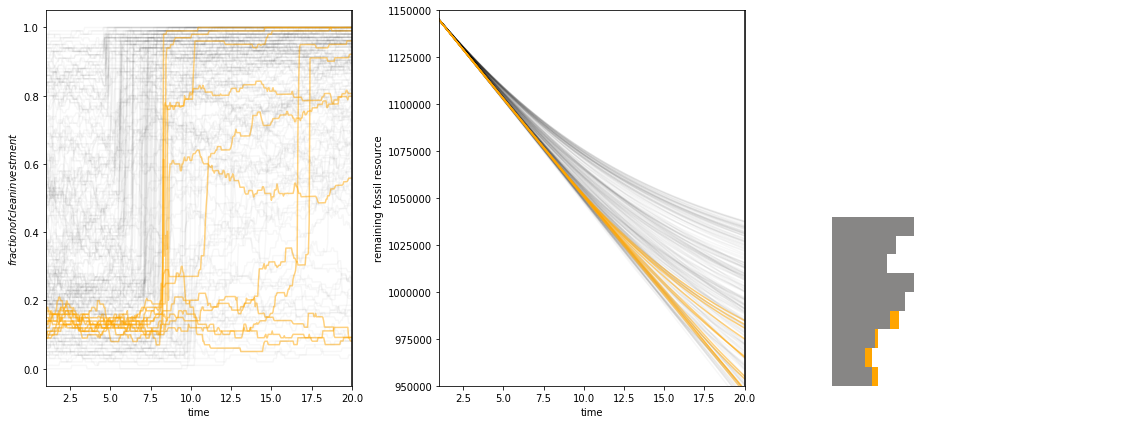

In [101]:
from collections import Counter

t_max = 20

fig, axes = plt.subplots(ncols=3, figsize=(16, 6))

def plot_cond(df, c, ax, t_max, thresh=0.5, c_df=None):
    tmp = df
    if c_df is None:
        c_tmp = tmp
    else:
        c_tmp = c_df
    tmp1 = tmp[[c]].loc[c_tmp['inv_distance']<thresh]
    tmp2 = tmp[[c]].loc[c_tmp['inv_distance']>thresh]
    try:
        tmp1.unstack('sample').loc[:t_max].plot(ax=ax, alpha=.03, legend=False, color=['k'])
    except TypeError:
        print('no data')
    try:
        tmp2.unstack('sample').loc[:t_max].plot(ax=ax, legend=False, alpha=.5, color=['orange'])
    except TypeError:
        print('no data')
    
thresh=0.5

plot_cond(cond, 'b', axes[0], t_max, thresh=thresh)
plot_cond(trj, 'G', axes[1], t_max, thresh=thresh, c_df=cond)

tmp = trj.xs(level='tstep', key=t_max)[['G']]
tmp_cond = cond.xs(level='tstep', key=t_max)
tmp['close'] = float('nan')
tmp['far'] = float('nan')
tmp.loc[tmp_cond['inv_distance']<thresh, 'far'] = tmp.loc[tmp_cond['inv_distance']<thresh, 'G']
tmp.loc[tmp_cond['inv_distance']>thresh, 'close'] = tmp.loc[tmp_cond['inv_distance']>thresh, 'G']

tmp[['far', 'close']].plot(kind='hist',
                           ax=axes[2],
                           stacked=True,
                           colors=['#878685', 'orange'],
                           orientation='horizontal',
                           bins=range(950000, 1150000, 10000),
                          legend=False)

#plt.yscale('log', nonposy='clip')

# dfN['weight'].loc[dfN['weight']<thresh].plot(ax=axes[2], style='.', alpha=0.3, color='k')
# dfN['weight'].loc[dfN['weight']>thresh].plot(ax=axes[2], style='.', color='orange')

for ax in axes[1:]:
    ax.set_ylim([950000, 1150000])

axes[2].set_xlim([0,100])    
axes[2].axis('off')

for ax in axes[:2]:
    ax.set_xlim([1,20])
    ax.set_xlabel('time')
    ax.axvline(t_max, color='k')

axes[0].set_ylabel(r'$fraction of clean investment$')
axes[1].set_ylabel('remaining fossil resource')

fig.tight_layout()
fig.savefig('initial_condition_sampling.pdf')

In [104]:
trj.index.get_index_level_values

Float64Index([                0.0,                0.05,                 0.1,
              0.15000000000000002,                 0.2,                0.25,
              0.30000000000000004, 0.35000000000000003,                 0.4,
                             0.45,
              ...
                            19.55,                19.6,  19.650000000000002,
               19.700000000000003,               19.75,                19.8,
                            19.85,  19.900000000000002,  19.950000000000003,
                             20.0],
             dtype='float64', name='tstep', length=401)

In [92]:
list(range(950000, 1150000, 10000))

[950000,
 960000,
 970000,
 980000,
 990000,
 1000000,
 1010000,
 1020000,
 1030000,
 1040000,
 1050000,
 1060000,
 1070000,
 1080000,
 1090000,
 1100000,
 1110000,
 1120000,
 1130000,
 1140000]

In [65]:
(cond.xs(level='tstep', key=1)[['inv_distance']]>thresh).values.T

array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False,  True, False, False, False,
        False, False, False,  True, False, False, False, False,  True,
         True, False, False, False, False, False, False, False, False,
        False, False, False, False, False,  True, False, False, False,
         True,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
      

In [25]:
tmp['close']

sample
2     NaN
0     NaN
3     NaN
1     NaN
4     NaN
6     NaN
7     NaN
8     NaN
5     NaN
9     NaN
10    NaN
11    NaN
13    NaN
12    NaN
15    NaN
14    NaN
16    NaN
17    NaN
19    NaN
20    NaN
21    NaN
22    NaN
18    NaN
24    NaN
25    NaN
23    NaN
27    NaN
28    NaN
29    NaN
26    NaN
       ..
168   NaN
171   NaN
172   NaN
173   NaN
175   NaN
176   NaN
174   NaN
177   NaN
178   NaN
179   NaN
181   NaN
182   NaN
183   NaN
180   NaN
185   NaN
186   NaN
187   NaN
184   NaN
189   NaN
190   NaN
191   NaN
188   NaN
192   NaN
193   NaN
194   NaN
195   NaN
196   NaN
197   NaN
198   NaN
199   NaN
Name: close, Length: 200, dtype: float64